# Part 2, Beat IBB Index

The second part of application in the paper is to select a subset of stocks from IBB Index to beat the Index.

In [60]:
# Run some setup code for this notebook.
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

** Load data **

- `index_col = 0`: since first column is date (useless for training), let's keep it as index
- `dropna(axis=1, how='any')`: drop any stock with any n/a (missing) data
- `astype('float32')`: datatype

Finally we only have **83** stocks to use.

In [61]:
# Load data

# stock componenet data
stock = defaultdict(defaultdict)

stock_lp = pd.read_csv('data/last_price.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['lp'] = stock_lp.iloc[0:104, :]
stock['validate']['lp'] = stock_lp.iloc[104:, :]

stock_net = pd.read_csv('data/net_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['net'] = stock_net.iloc[0:104, :]
stock['validate']['net'] = stock_net.iloc[104:, :]

stock_percentage = pd.read_csv('data/percentage_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['percentage'] = stock_percentage.iloc[0:104, :]
stock['validate']['percentage'] = stock_percentage.iloc[104:, :]


# ibb data
ibb = defaultdict(defaultdict)
ibb_full = pd.read_csv('data/ibb.csv', index_col=0).astype('float32')

ibb_lp = ibb_full.iloc[:,0] # Series
ibb['calibrate']['lp'] = ibb_lp[0:104]
ibb['validate']['lp'] = ibb_lp[104:]

ibb_net = ibb_full.iloc[:,1] # Series
ibb['calibrate']['net'] = ibb_net[0:104]
ibb['validate']['net'] = ibb_net[104:]

ibb_percentage = ibb_full.iloc[:,2] # Series
ibb['calibrate']['percentage'] = ibb_percentage[0:104]
ibb['validate']['percentage'] = ibb_percentage[104:]

# Phase 1. Auto-encoding

1. Train an auto-encoder model compressing market information.
2. Rank stocks by 2-norm difference then select subset of them as our portfolio.
3. Page 7 of the paper: ReLU + linear as activation functions
4. Weights $W = (W_1, W_2)$, L2 regularization


Some problems I did not figure out (or the paper did not mention about the details):
1. which weekly return/what data to be used? (what can represent best market information?)
2. How to do the data preprocessing?
3. How to perform 4-fold validation in Deep Learning?

In [62]:
encoding_dim = 5 # 5 neurons
num_stock = len(stock_lp.columns) # Use 83 stocks as features

# connect all layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # see 'Stacked Auto-Encoders' in paper

# construct and compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder
data = stock['calibrate']['net']
autoencoder.fit(data, data, shuffle=False, epochs=500, batch_size = 10)
autoencoder.save('model/beat_autoencoder.h5')

# test/reconstruct market information matrix
reconstruct = autoencoder.predict(data)

Epoch 1/500
104/104 [==============================] - 1s 9ms/step - loss: 5.7999
Epoch 2/500
104/104 [==============================] - 0s 234us/step - loss: 5.6047
Epoch 3/500
104/104 [==============================] - 0s 237us/step - loss: 5.5153
Epoch 4/500
104/104 [==============================] - 0s 249us/step - loss: 5.4541
Epoch 5/500
104/104 [==============================] - 0s 268us/step - loss: 5.4033
Epoch 6/500
104/104 [==============================] - 0s 263us/step - loss: 5.3548
Epoch 7/500
104/104 [==============================] - 0s 238us/step - loss: 5.3053
Epoch 8/500
104/104 [==============================] - 0s 263us/step - loss: 5.2516
Epoch 9/500
104/104 [==============================] - 0s 234us/step - loss: 5.1890
Epoch 10/500
104/104 [==============================] - 0s 267us/step - loss: 5.1137
Epoch 11/500
104/104 [==============================] - 0s 256us/step - loss: 5.0237
Epoch 12/500
104/104 [==============================] - 0s 234us/step - loss

104/104 [==============================] - 0s 221us/step - loss: 2.6058
Epoch 98/500
104/104 [==============================] - 0s 249us/step - loss: 2.6005
Epoch 99/500
104/104 [==============================] - 0s 236us/step - loss: 2.5953
Epoch 100/500
104/104 [==============================] - 0s 277us/step - loss: 2.5901
Epoch 101/500
104/104 [==============================] - 0s 262us/step - loss: 2.5850
Epoch 102/500
104/104 [==============================] - 0s 283us/step - loss: 2.5799
Epoch 103/500
104/104 [==============================] - 0s 277us/step - loss: 2.5748
Epoch 104/500
104/104 [==============================] - 0s 270us/step - loss: 2.5698
Epoch 105/500
104/104 [==============================] - 0s 263us/step - loss: 2.5647
Epoch 106/500
104/104 [==============================] - 0s 234us/step - loss: 2.5598
Epoch 107/500
104/104 [==============================] - 0s 208us/step - loss: 2.5548
Epoch 108/500
104/104 [==============================] - 0s 268us/step

104/104 [==============================] - 0s 262us/step - loss: 2.3081
Epoch 192/500
104/104 [==============================] - 0s 256us/step - loss: 2.3068
Epoch 193/500
104/104 [==============================] - 0s 269us/step - loss: 2.3056
Epoch 194/500
104/104 [==============================] - 0s 266us/step - loss: 2.3043
Epoch 195/500
104/104 [==============================] - 0s 235us/step - loss: 2.3030
Epoch 196/500
104/104 [==============================] - 0s 246us/step - loss: 2.3018
Epoch 197/500
104/104 [==============================] - 0s 220us/step - loss: 2.3006
Epoch 198/500
104/104 [==============================] - 0s 234us/step - loss: 2.2994
Epoch 199/500
104/104 [==============================] - 0s 242us/step - loss: 2.2983
Epoch 200/500
104/104 [==============================] - 0s 240us/step - loss: 2.2971
Epoch 201/500
104/104 [==============================] - 0s 247us/step - loss: 2.2960
Epoch 202/500
104/104 [==============================] - 0s 282us/st

104/104 [==============================] - 0s 202us/step - loss: 2.2471
Epoch 287/500
104/104 [==============================] - 0s 305us/step - loss: 2.2468
Epoch 288/500
104/104 [==============================] - 0s 247us/step - loss: 2.2466
Epoch 289/500
104/104 [==============================] - 0s 207us/step - loss: 2.2463
Epoch 290/500
104/104 [==============================] - 0s 177us/step - loss: 2.2460
Epoch 291/500
104/104 [==============================] - 0s 213us/step - loss: 2.2457
Epoch 292/500
104/104 [==============================] - 0s 221us/step - loss: 2.2454
Epoch 293/500
104/104 [==============================] - 0s 754us/step - loss: 2.2452
Epoch 294/500
104/104 [==============================] - 0s 344us/step - loss: 2.2449
Epoch 295/500
104/104 [==============================] - 0s 325us/step - loss: 2.2446
Epoch 296/500
104/104 [==============================] - 0s 394us/step - loss: 2.2444
Epoch 297/500
104/104 [==============================] - 0s 509us/st

104/104 [==============================] - 0s 284us/step - loss: 2.2265
Epoch 381/500
104/104 [==============================] - 0s 288us/step - loss: 2.2264
Epoch 382/500
104/104 [==============================] - 0s 288us/step - loss: 2.2262
Epoch 383/500
104/104 [==============================] - 0s 274us/step - loss: 2.2261
Epoch 384/500
104/104 [==============================] - 0s 229us/step - loss: 2.2259
Epoch 385/500
104/104 [==============================] - 0s 265us/step - loss: 2.2257
Epoch 386/500
104/104 [==============================] - 0s 275us/step - loss: 2.2256
Epoch 387/500
104/104 [==============================] - 0s 270us/step - loss: 2.2254
Epoch 388/500
104/104 [==============================] - 0s 253us/step - loss: 2.2253
Epoch 389/500
104/104 [==============================] - 0s 209us/step - loss: 2.2251
Epoch 390/500
104/104 [==============================] - 0s 220us/step - loss: 2.2250
Epoch 391/500
104/104 [==============================] - 0s 296us/st

104/104 [==============================] - 0s 400us/step - loss: 2.2158
Epoch 475/500
104/104 [==============================] - 0s 281us/step - loss: 2.2157
Epoch 476/500
104/104 [==============================] - 0s 242us/step - loss: 2.2156
Epoch 477/500
104/104 [==============================] - 0s 216us/step - loss: 2.2155
Epoch 478/500
104/104 [==============================] - 0s 239us/step - loss: 2.2154
Epoch 479/500
104/104 [==============================] - 0s 225us/step - loss: 2.2153
Epoch 480/500
104/104 [==============================] - 0s 219us/step - loss: 2.2152
Epoch 481/500
104/104 [==============================] - 0s 186us/step - loss: 2.2151
Epoch 482/500
104/104 [==============================] - 0s 217us/step - loss: 2.2150
Epoch 483/500
104/104 [==============================] - 0s 216us/step - loss: 2.2149
Epoch 484/500
104/104 [==============================] - 0s 210us/step - loss: 2.2148
Epoch 485/500
104/104 [==============================] - 0s 693us/st

** Communal Information **

- Compute $||X - \hat{X}||$ as 2 norm difference
- The least 2 norm difference a stock has, the more important role it plays in the compressed market auto-encoder
- The paper says that, AMGN should be the best, and BCRX should be the worst. (But I didn't achieve this result.)

In [63]:
communal_information = []

for i in range(0,83):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock #, 2-norm, stock name")
ranking = np.array(communal_information).argsort()
for stock_index in ranking:
    print(stock_index, communal_information[stock_index], stock['calibrate']['net'].iloc[:,stock_index].name) # print stock name from lowest different to highest

stock #, 2-norm, stock name
68 1.288070797920227 TLGT    US Equity
65 1.321529507637024 INO     US Equity
38 1.6224092245101929 LXRX    US Equity
76 1.8336045742034912 NVAX    US Equity
66 2.0743954181671143 CERS    US Equity
79 2.180755138397217 ZGNX    US Equity
81 2.4205305576324463 MNOV    US Equity
77 2.4227540493011475 PDLI    US Equity
71 2.5004076957702637 CRIS    US Equity
52 2.7980635166168213 IMMU    US Equity
17 2.858445644378662 EXEL    US Equity
75 3.101935386657715 GERN    US Equity
49 3.104473352432251 DEPO    US Equity
37 3.432741641998291 ARRY    US Equity
73 3.605278491973877 AVDL    US Equity
67 3.6483685970306396 PACB    US Equity
48 3.875211000442505 SGYP    US Equity
19 4.003232479095459 OPK     US Equity
42 4.117496967315674 RGEN    US Equity
55 4.188165187835693 BCRX    US Equity
31 4.208094596862793 HZNP    US Equity
72 4.267415523529053 PRTK    US Equity
82 4.347030162811279 ARWR    US Equity
80 4.5980401039123535 CGEN    US Equity
69 4.860776424407959 RIGL  

Let's have a look on how well this auto-encoder works on a certain stock.

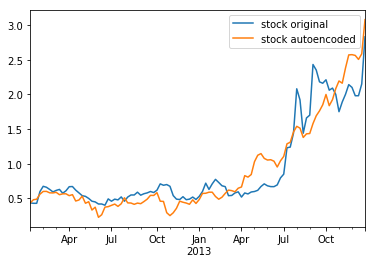

In [66]:
which_stock = 65

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='stock autoencoded', legend=True)

# Phase 2: Calibrating

For the application of beating the IBB index, we will amend the target data during the calibration phase by replacing all returns smaller than -5% by exactly 5%, which aims to create an index tracker with anti-correlation in periods of large drawdowns.

The comparison is shown as bellow.

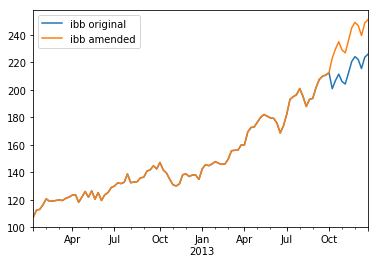

In [67]:
# from -5% to 5%
y_amended = ibb['calibrate']['percentage']
y_amended[y_amended < -5] = 5

# re-calculate the last price
y_amended[0] = 0
relative_percentage = (y_amended /100) + 1
lp_amended = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod()) 

# plot comparison
pd.Series(ibb['calibrate']['lp'].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb original', legend=True) 
pd.Series(lp_amended.as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb amended', legend=True)   

In [68]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.005))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.005))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = y_amended # amended percentage
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 10)    # fit the model
    deep_learner.save('model/beat_s' + str(s) + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage/100) + 1
    
    ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - lp_amended)) # compare with amended last price

Epoch 1/500
104/104 [==============================] - 1s 13ms/step - loss: 9.1094
Epoch 2/500
104/104 [==============================] - 0s 160us/step - loss: 5.1081
Epoch 3/500
104/104 [==============================] - 0s 151us/step - loss: 3.7867
Epoch 4/500
104/104 [==============================] - 0s 172us/step - loss: 3.0469
Epoch 5/500
104/104 [==============================] - 0s 170us/step - loss: 2.5905
Epoch 6/500
104/104 [==============================] - 0s 294us/step - loss: 2.2992
Epoch 7/500
104/104 [==============================] - 0s 494us/step - loss: 2.0913
Epoch 8/500
104/104 [==============================] - 0s 259us/step - loss: 1.9365
Epoch 9/500
104/104 [==============================] - 0s 303us/step - loss: 1.7954
Epoch 10/500
104/104 [==============================] - 0s 324us/step - loss: 1.6589
Epoch 11/500
104/104 [==============================] - 0s 251us/step - loss: 1.5455
Epoch 12/500
104/104 [==============================] - 0s 251us/step - los

Epoch 97/500
104/104 [==============================] - 0s 210us/step - loss: 0.4265
Epoch 98/500
104/104 [==============================] - 0s 278us/step - loss: 0.4251
Epoch 99/500
104/104 [==============================] - 0s 422us/step - loss: 0.4189
Epoch 100/500
104/104 [==============================] - 0s 203us/step - loss: 0.4191
Epoch 101/500
104/104 [==============================] - 0s 188us/step - loss: 0.4172
Epoch 102/500
104/104 [==============================] - 0s 170us/step - loss: 0.4127
Epoch 103/500
104/104 [==============================] - 0s 276us/step - loss: 0.4120
Epoch 104/500
104/104 [==============================] - 0s 352us/step - loss: 0.4077
Epoch 105/500
104/104 [==============================] - 0s 398us/step - loss: 0.4060
Epoch 106/500
104/104 [==============================] - 0s 290us/step - loss: 0.4058
Epoch 107/500
104/104 [==============================] - 0s 525us/step - loss: 0.4001
Epoch 108/500
104/104 [==============================] - 

104/104 [==============================] - 0s 233us/step - loss: 0.2583
Epoch 193/500
104/104 [==============================] - 0s 183us/step - loss: 0.2596
Epoch 194/500
104/104 [==============================] - 0s 176us/step - loss: 0.2562
Epoch 195/500
104/104 [==============================] - 0s 168us/step - loss: 0.2575
Epoch 196/500
104/104 [==============================] - 0s 167us/step - loss: 0.2548
Epoch 197/500
104/104 [==============================] - 0s 160us/step - loss: 0.2559
Epoch 198/500
104/104 [==============================] - 0s 177us/step - loss: 0.2523
Epoch 199/500
104/104 [==============================] - 0s 171us/step - loss: 0.2548
Epoch 200/500
104/104 [==============================] - 0s 158us/step - loss: 0.2516
Epoch 201/500
104/104 [==============================] - 0s 159us/step - loss: 0.2518
Epoch 202/500
104/104 [==============================] - 0s 175us/step - loss: 0.2496
Epoch 203/500
104/104 [==============================] - 0s 183us/st

104/104 [==============================] - 0s 177us/step - loss: 0.2019
Epoch 288/500
104/104 [==============================] - 0s 222us/step - loss: 0.2006
Epoch 289/500
104/104 [==============================] - 0s 229us/step - loss: 0.2002
Epoch 290/500
104/104 [==============================] - 0s 271us/step - loss: 0.1995
Epoch 291/500
104/104 [==============================] - 0s 157us/step - loss: 0.2005
Epoch 292/500
104/104 [==============================] - 0s 162us/step - loss: 0.1998
Epoch 293/500
104/104 [==============================] - 0s 175us/step - loss: 0.1993
Epoch 294/500
104/104 [==============================] - 0s 176us/step - loss: 0.1983
Epoch 295/500
104/104 [==============================] - 0s 182us/step - loss: 0.1986
Epoch 296/500
104/104 [==============================] - 0s 160us/step - loss: 0.1975
Epoch 297/500
104/104 [==============================] - 0s 190us/step - loss: 0.1977
Epoch 298/500
104/104 [==============================] - 0s 178us/st

104/104 [==============================] - 0s 180us/step - loss: 0.1760
Epoch 383/500
104/104 [==============================] - 0s 201us/step - loss: 0.1755
Epoch 384/500
104/104 [==============================] - 0s 183us/step - loss: 0.1753
Epoch 385/500
104/104 [==============================] - 0s 214us/step - loss: 0.1745
Epoch 386/500
104/104 [==============================] - 0s 244us/step - loss: 0.1747
Epoch 387/500
104/104 [==============================] - 0s 220us/step - loss: 0.1748
Epoch 388/500
104/104 [==============================] - 0s 205us/step - loss: 0.1739
Epoch 389/500
104/104 [==============================] - 0s 276us/step - loss: 0.1738
Epoch 390/500
104/104 [==============================] - 0s 250us/step - loss: 0.1742
Epoch 391/500
104/104 [==============================] - 0s 171us/step - loss: 0.1739
Epoch 392/500
104/104 [==============================] - 0s 170us/step - loss: 0.1731
Epoch 393/500
104/104 [==============================] - 0s 161us/st

104/104 [==============================] - 0s 232us/step - loss: 0.1567
Epoch 477/500
104/104 [==============================] - 0s 232us/step - loss: 0.1568
Epoch 478/500
104/104 [==============================] - 0s 204us/step - loss: 0.1566
Epoch 479/500
104/104 [==============================] - 0s 305us/step - loss: 0.1564
Epoch 480/500
104/104 [==============================] - 0s 208us/step - loss: 0.1563
Epoch 481/500
104/104 [==============================] - 0s 213us/step - loss: 0.1560
Epoch 482/500
104/104 [==============================] - 0s 188us/step - loss: 0.1561
Epoch 483/500
104/104 [==============================] - 0s 182us/step - loss: 0.1560
Epoch 484/500
104/104 [==============================] - 0s 174us/step - loss: 0.1555
Epoch 485/500
104/104 [==============================] - 0s 198us/step - loss: 0.1556
Epoch 486/500
104/104 [==============================] - 0s 186us/step - loss: 0.1557
Epoch 487/500
104/104 [==============================] - 0s 199us/st

104/104 [==============================] - 0s 247us/step - loss: 0.3330
Epoch 73/500
104/104 [==============================] - 0s 226us/step - loss: 0.3319
Epoch 74/500
104/104 [==============================] - 0s 194us/step - loss: 0.3324
Epoch 75/500
104/104 [==============================] - 0s 188us/step - loss: 0.3299
Epoch 76/500
104/104 [==============================] - 0s 169us/step - loss: 0.3283
Epoch 77/500
104/104 [==============================] - 0s 170us/step - loss: 0.3260
Epoch 78/500
104/104 [==============================] - 0s 191us/step - loss: 0.3236
Epoch 79/500
104/104 [==============================] - 0s 171us/step - loss: 0.3218
Epoch 80/500
104/104 [==============================] - 0s 167us/step - loss: 0.3198
Epoch 81/500
104/104 [==============================] - 0s 206us/step - loss: 0.3193
Epoch 82/500
104/104 [==============================] - 0s 172us/step - loss: 0.3216
Epoch 83/500
104/104 [==============================] - 0s 165us/step - loss: 

104/104 [==============================] - 0s 287us/step - loss: 0.2500
Epoch 168/500
104/104 [==============================] - 0s 195us/step - loss: 0.2494
Epoch 169/500
104/104 [==============================] - 0s 191us/step - loss: 0.2488
Epoch 170/500
104/104 [==============================] - 0s 163us/step - loss: 0.2483
Epoch 171/500
104/104 [==============================] - 0s 161us/step - loss: 0.2492
Epoch 172/500
104/104 [==============================] - 0s 191us/step - loss: 0.2515
Epoch 173/500
104/104 [==============================] - 0s 188us/step - loss: 0.2523
Epoch 174/500
104/104 [==============================] - 0s 164us/step - loss: 0.2492
Epoch 175/500
104/104 [==============================] - 0s 167us/step - loss: 0.2480
Epoch 176/500
104/104 [==============================] - 0s 180us/step - loss: 0.2472
Epoch 177/500
104/104 [==============================] - 0s 178us/step - loss: 0.2467
Epoch 178/500
104/104 [==============================] - ETA: 0s - l

104/104 [==============================] - 0s 182us/step - loss: 0.2267
Epoch 262/500
104/104 [==============================] - 0s 188us/step - loss: 0.2263
Epoch 263/500
104/104 [==============================] - 0s 180us/step - loss: 0.2261
Epoch 264/500
104/104 [==============================] - 0s 165us/step - loss: 0.2258
Epoch 265/500
104/104 [==============================] - 0s 161us/step - loss: 0.2255
Epoch 266/500
104/104 [==============================] - 0s 185us/step - loss: 0.2252
Epoch 267/500
104/104 [==============================] - 0s 179us/step - loss: 0.2250
Epoch 268/500
104/104 [==============================] - 0s 156us/step - loss: 0.2247
Epoch 269/500
104/104 [==============================] - 0s 158us/step - loss: 0.2245
Epoch 270/500
104/104 [==============================] - 0s 206us/step - loss: 0.2256
Epoch 271/500
104/104 [==============================] - 0s 177us/step - loss: 0.2308
Epoch 272/500
104/104 [==============================] - 0s 181us/st

104/104 [==============================] - 0s 188us/step - loss: 0.2176
Epoch 357/500
104/104 [==============================] - 0s 184us/step - loss: 0.2198
Epoch 358/500
104/104 [==============================] - 0s 178us/step - loss: 0.2207
Epoch 359/500
104/104 [==============================] - 0s 172us/step - loss: 0.2181
Epoch 360/500
104/104 [==============================] - 0s 176us/step - loss: 0.2172
Epoch 361/500
104/104 [==============================] - 0s 171us/step - loss: 0.2168
Epoch 362/500
104/104 [==============================] - 0s 182us/step - loss: 0.2165
Epoch 363/500
104/104 [==============================] - 0s 162us/step - loss: 0.2163
Epoch 364/500
104/104 [==============================] - 0s 184us/step - loss: 0.2160
Epoch 365/500
104/104 [==============================] - 0s 166us/step - loss: 0.2158
Epoch 366/500
104/104 [==============================] - 0s 159us/step - loss: 0.2156
Epoch 367/500
104/104 [==============================] - 0s 175us/st

104/104 [==============================] - 0s 185us/step - loss: 0.2108
Epoch 452/500
104/104 [==============================] - 0s 184us/step - loss: 0.2106
Epoch 453/500
104/104 [==============================] - 0s 188us/step - loss: 0.2104
Epoch 454/500
104/104 [==============================] - 0s 158us/step - loss: 0.2103
Epoch 455/500
104/104 [==============================] - 0s 165us/step - loss: 0.2101
Epoch 456/500
104/104 [==============================] - ETA: 0s - loss: 0.062 - 0s 176us/step - loss: 0.2100
Epoch 457/500
104/104 [==============================] - 0s 188us/step - loss: 0.2099
Epoch 458/500
104/104 [==============================] - 0s 174us/step - loss: 0.2097
Epoch 459/500
104/104 [==============================] - 0s 173us/step - loss: 0.2096
Epoch 460/500
104/104 [==============================] - 0s 166us/step - loss: 0.2095
Epoch 461/500
104/104 [==============================] - 0s 165us/step - loss: 0.2094
Epoch 462/500
104/104 [=====================

104/104 [==============================] - 0s 339us/step - loss: 0.2831
Epoch 47/500
104/104 [==============================] - 0s 218us/step - loss: 0.2729
Epoch 48/500
104/104 [==============================] - 0s 224us/step - loss: 0.2653
Epoch 49/500
104/104 [==============================] - 0s 179us/step - loss: 0.2614
Epoch 50/500
104/104 [==============================] - 0s 173us/step - loss: 0.2604
Epoch 51/500
104/104 [==============================] - 0s 219us/step - loss: 0.2507
Epoch 52/500
104/104 [==============================] - 0s 219us/step - loss: 0.2430
Epoch 53/500
104/104 [==============================] - 0s 193us/step - loss: 0.2376
Epoch 54/500
104/104 [==============================] - 0s 209us/step - loss: 0.2375
Epoch 55/500
104/104 [==============================] - 0s 218us/step - loss: 0.2282
Epoch 56/500
104/104 [==============================] - 0s 447us/step - loss: 0.2208
Epoch 57/500
104/104 [==============================] - 0s 365us/step - loss: 

104/104 [==============================] - 0s 296us/step - loss: 0.0894
Epoch 141/500
104/104 [==============================] - 0s 216us/step - loss: 0.0888
Epoch 142/500
104/104 [==============================] - 0s 230us/step - loss: 0.0887
Epoch 143/500
104/104 [==============================] - 0s 208us/step - loss: 0.0881
Epoch 144/500
104/104 [==============================] - 0s 222us/step - loss: 0.0879
Epoch 145/500
104/104 [==============================] - 0s 189us/step - loss: 0.0876
Epoch 146/500
104/104 [==============================] - 0s 239us/step - loss: 0.0873
Epoch 147/500
104/104 [==============================] - 0s 209us/step - loss: 0.0870
Epoch 148/500
104/104 [==============================] - 0s 180us/step - loss: 0.0866
Epoch 149/500
104/104 [==============================] - 0s 165us/step - loss: 0.0864
Epoch 150/500
104/104 [==============================] - 0s 211us/step - loss: 0.0860
Epoch 151/500
104/104 [==============================] - 0s 201us/st

104/104 [==============================] - 0s 214us/step - loss: 0.0750
Epoch 235/500
104/104 [==============================] - 0s 188us/step - loss: 0.0749
Epoch 236/500
104/104 [==============================] - 0s 213us/step - loss: 0.0749
Epoch 237/500
104/104 [==============================] - 0s 154us/step - loss: 0.0748
Epoch 238/500
104/104 [==============================] - 0s 202us/step - loss: 0.0747
Epoch 239/500
104/104 [==============================] - 0s 171us/step - loss: 0.0746
Epoch 240/500
104/104 [==============================] - 0s 222us/step - loss: 0.0746
Epoch 241/500
104/104 [==============================] - 0s 208us/step - loss: 0.0745
Epoch 242/500
104/104 [==============================] - 0s 230us/step - loss: 0.0745
Epoch 243/500
104/104 [==============================] - 0s 198us/step - loss: 0.0744
Epoch 244/500
104/104 [==============================] - 0s 171us/step - loss: 0.0744
Epoch 245/500
104/104 [==============================] - 0s 170us/st

104/104 [==============================] - 0s 198us/step - loss: 0.0702
Epoch 329/500
104/104 [==============================] - 0s 244us/step - loss: 0.0702
Epoch 330/500
104/104 [==============================] - 0s 219us/step - loss: 0.0701
Epoch 331/500
104/104 [==============================] - 0s 195us/step - loss: 0.0701
Epoch 332/500
104/104 [==============================] - 0s 192us/step - loss: 0.0700
Epoch 333/500
104/104 [==============================] - ETA: 0s - loss: 0.091 - 0s 182us/step - loss: 0.0700
Epoch 334/500
104/104 [==============================] - 0s 184us/step - loss: 0.0699
Epoch 335/500
104/104 [==============================] - 0s 175us/step - loss: 0.0699
Epoch 336/500
104/104 [==============================] - 0s 177us/step - loss: 0.0699
Epoch 337/500
104/104 [==============================] - 0s 165us/step - loss: 0.0698
Epoch 338/500
104/104 [==============================] - 0s 198us/step - loss: 0.0698
Epoch 339/500
104/104 [=====================

104/104 [==============================] - 0s 253us/step - loss: 0.0667
Epoch 423/500
104/104 [==============================] - 0s 235us/step - loss: 0.0666
Epoch 424/500
104/104 [==============================] - 0s 199us/step - loss: 0.0666
Epoch 425/500
104/104 [==============================] - 0s 177us/step - loss: 0.0666
Epoch 426/500
104/104 [==============================] - 0s 177us/step - loss: 0.0666
Epoch 427/500
104/104 [==============================] - 0s 170us/step - loss: 0.0665
Epoch 428/500
104/104 [==============================] - 0s 171us/step - loss: 0.0665
Epoch 429/500
104/104 [==============================] - 0s 175us/step - loss: 0.0665
Epoch 430/500
104/104 [==============================] - 0s 231us/step - loss: 0.0664
Epoch 431/500
104/104 [==============================] - 0s 219us/step - loss: 0.0664
Epoch 432/500
104/104 [==============================] - 0s 176us/step - loss: 0.0664
Epoch 433/500
104/104 [==============================] - 0s 206us/st

Now we would like to see how similar these 3 portfolios perfom as the modified(amended) IBB Index does on training dates.

S25 2-norm difference:  10.0282
S45 2-norm difference:  35.3057
S65 2-norm difference:  14.6669


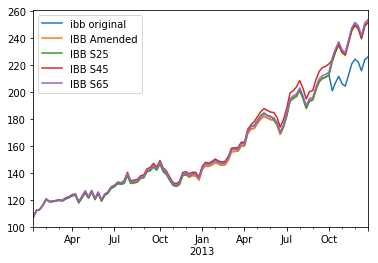

In [69]:
# plot results and 2-norm differences 
pd.Series(ibb['calibrate']['lp'].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb original', legend=True) 
pd.Series(lp_amended.as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='IBB Amended', legend=True)

for s in [25, 45, 65]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    


# Phase 3: Validating

In [70]:
for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/beat_s' + str(s) + '.h5')
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage/100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
#     total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))

Again, we would like to see how similar these 3 portfolios perform as the original IBB Index does, but on test dates.

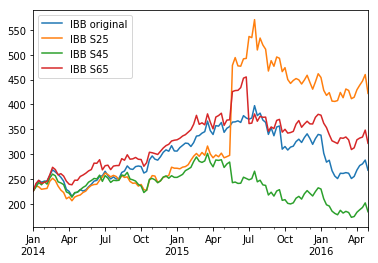

In [71]:
# plot original IBB last price
pd.Series(ibb['validate']['lp'].as_matrix(), index=pd.date_range(start='01/03/2014', periods=122, freq='W')).plot(label='IBB original', legend=True) 

# 2-norm difference is now meaningless to compare
for s in [25, 45, 65]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='01/03/2014', periods = 122,freq='W')).plot(label='IBB S'+str(s), legend=True)